# 01. DQN基礎 - Deep Q-Networkによる強化学習

このノートブックでは、DQN（Deep Q-Network）アルゴリズムを使ってCartPole環境でエージェントを訓練します。

## DQNとは

DQN（Deep Q-Network）は、Q学習とディープニューラルネットワークを組み合わせた強化学習アルゴリズムです：

- **Q学習**: 状態-行動価値関数（Q値）を学習し、最適な行動を選択
- **Experience Replay**: 過去の経験をバッファに保存し、ランダムにサンプリングして学習
- **Target Network**: 安定した学習のために、別のネットワークで目標値を計算

## 要件
- 要件 1.2: CartPoleでDQNエージェントを訓練し、エピソード報酬の学習曲線を記録

In [1]:
# 必要なライブラリのインポート
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback
import warnings
import japanize_matplotlib
warnings.filterwarnings('ignore')

print("✅ ライブラリのインポート完了")

✅ ライブラリのインポート完了


## 1. CartPole環境の確認

DQNで訓練する前に、環境の詳細を確認します。

In [2]:
# CartPole環境の作成
env = gym.make('CartPole-v1', render_mode='rgb_array')

print(f"観測空間: {env.observation_space}")
print(f"行動空間: {env.action_space}")
print(f"最大エピソード長: 500ステップ")
print("\n観測の内容:")
print("  [0] カート位置 (-4.8 ~ 4.8)")
print("  [1] カート速度")
print("  [2] ポール角度 (-0.418 ~ 0.418 rad ≈ -24° ~ 24°)")
print("  [3] ポール角速度")
print("\n行動:")
print("  0: 左に押す")
print("  1: 右に押す")

env.close()

観測空間: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
行動空間: Discrete(2)
最大エピソード長: 500ステップ

観測の内容:
  [0] カート位置 (-4.8 ~ 4.8)
  [1] カート速度
  [2] ポール角度 (-0.418 ~ 0.418 rad ≈ -24° ~ 24°)
  [3] ポール角速度

行動:
  0: 左に押す
  1: 右に押す


## 2. 学習曲線記録用のコールバック

訓練中のパフォーマンスを記録するためのカスタムコールバックを定義します。

In [3]:
class LearningCurveCallback(BaseCallback):
    """
    訓練中の学習曲線を記録するコールバック
    
    定期的にモデルを評価し、平均報酬を記録します。
    """
    def __init__(self, eval_env, eval_freq=2000, n_eval_episodes=5, verbose=1):
        super().__init__(verbose)
        self.eval_env = eval_env
        self.eval_freq = eval_freq
        self.n_eval_episodes = n_eval_episodes
        self.timesteps = []
        self.mean_rewards = []
        self.std_rewards = []
    
    def _on_step(self) -> bool:
        # eval_freq回ごとに評価
        if self.n_calls % self.eval_freq == 0:
            # 現在のモデルを評価
            mean_reward, std_reward = evaluate_policy(
                self.model,
                self.eval_env,
                n_eval_episodes=self.n_eval_episodes,
                deterministic=True
            )
            
            self.timesteps.append(self.n_calls)
            self.mean_rewards.append(mean_reward)
            self.std_rewards.append(std_reward)
            
            if self.verbose > 0:
                print(f"  ステップ {self.n_calls}: 平均報酬 = {mean_reward:.2f} ± {std_reward:.2f}")
        
        return True

print("✅ コールバッククラス定義完了")

✅ コールバッククラス定義完了


## 3. DQNエージェントの訓練

DQNアルゴリズムを使ってエージェントを訓練します。

### DQNのハイパーパラメータ

- **learning_rate**: 学習率（0.0001）
- **buffer_size**: Experience Replayバッファのサイズ（50,000）
- **learning_starts**: 学習を開始するステップ数（1,000）
- **batch_size**: ミニバッチサイズ（32）
- **tau**: Target Networkの更新率（1.0 = ハードアップデート）
- **gamma**: 割引率（0.99）
- **target_update_interval**: Target Networkの更新頻度（500ステップ）
- **exploration_fraction**: ε-greedyの探索期間の割合（0.1）
- **exploration_initial_eps**: 初期探索率（1.0）
- **exploration_final_eps**: 最終探索率（0.05）

In [4]:
# 訓練用環境の作成
train_env = gym.make('CartPole-v1')
eval_env = gym.make('CartPole-v1')

# DQNモデルの作成
print("DQNエージェントを訓練中...")
print("\nDQNハイパーパラメータ:")
print("  学習率: 0.0001")
print("  バッファサイズ: 50,000")
print("  バッチサイズ: 32")
print("  割引率: 0.99")
print("  Target更新頻度: 500ステップ")
print("  探索率: 1.0 → 0.05 (最初の10%で減衰)\n")

model = DQN(
    "MlpPolicy",
    train_env,
    verbose=0,
    learning_rate=0.0001,
    buffer_size=50000,
    learning_starts=1000,
    batch_size=32,
    tau=1.0,
    gamma=0.99,
    target_update_interval=500,
    exploration_fraction=0.1,
    exploration_initial_eps=1.0,
    exploration_final_eps=0.05,
)

# コールバックの作成
callback = LearningCurveCallback(eval_env, eval_freq=2000, n_eval_episodes=5)

# 訓練実行（50,000ステップ）
model.learn(total_timesteps=50000, callback=callback, progress_bar=True)

print("\n✅ 訓練完了")

train_env.close()
eval_env.close()

DQNエージェントを訓練中...

DQNハイパーパラメータ:
  学習率: 0.0001
  バッファサイズ: 50,000
  バッチサイズ: 32
  割引率: 0.99
  Target更新頻度: 500ステップ
  探索率: 1.0 → 0.05 (最初の10%で減衰)



Output()

ステップ 2000: 平均報酬 = 9.20 ± 0.40

ステップ 4000: 平均報酬 = 9.20 ± 0.40

ステップ 6000: 平均報酬 = 9.40 ± 0.80

ステップ 8000: 平均報酬 = 9.60 ± 0.49

ステップ 10000: 平均報酬 = 9.20 ± 1.17

ステップ 12000: 平均報酬 = 13.00 ± 1.41

ステップ 14000: 平均報酬 = 9.20 ± 0.40

ステップ 16000: 平均報酬 = 8.80 ± 1.17

ステップ 18000: 平均報酬 = 8.80 ± 0.98

ステップ 20000: 平均報酬 = 9.60 ± 0.49

ステップ 22000: 平均報酬 = 9.60 ± 0.80

ステップ 24000: 平均報酬 = 9.60 ± 0.49

ステップ 26000: 平均報酬 = 9.60 ± 0.49

ステップ 28000: 平均報酬 = 9.40 ± 0.80

ステップ 30000: 平均報酬 = 9.60 ± 0.80

ステップ 32000: 平均報酬 = 9.20 ± 0.98

ステップ 34000: 平均報酬 = 9.20 ± 0.40

ステップ 36000: 平均報酬 = 8.80 ± 0.75

ステップ 38000: 平均報酬 = 9.40 ± 0.80

ステップ 40000: 平均報酬 = 9.00 ± 0.00

ステップ 42000: 平均報酬 = 9.60 ± 0.49

ステップ 44000: 平均報酬 = 9.00 ± 0.00

ステップ 46000: 平均報酬 = 9.80 ± 0.40

ステップ 48000: 平均報酬 = 9.40 ± 0.49

ステップ 50000: 平均報酬 = 9.20 ± 0.40


✅ 訓練完了


## 4. 訓練済みDQNエージェントの評価

In [5]:
# 訓練済みエージェントの評価
eval_env = gym.make('CartPole-v1')
mean_reward, std_reward = evaluate_policy(
    model,
    eval_env,
    n_eval_episodes=10,
    deterministic=True
)
eval_env.close()

print(f"訓練済みDQNエージェント:")
print(f"  平均報酬: {mean_reward:.2f} ± {std_reward:.2f}")
print(f"  最大報酬: 500.00 (CartPole-v1の上限)")

訓練済みDQNエージェント:
  平均報酬: 9.50 ± 0.81
  最大報酬: 500.00 (CartPole-v1の上限)


## 5. 学習曲線の可視化

訓練中のパフォーマンス向上を可視化します。

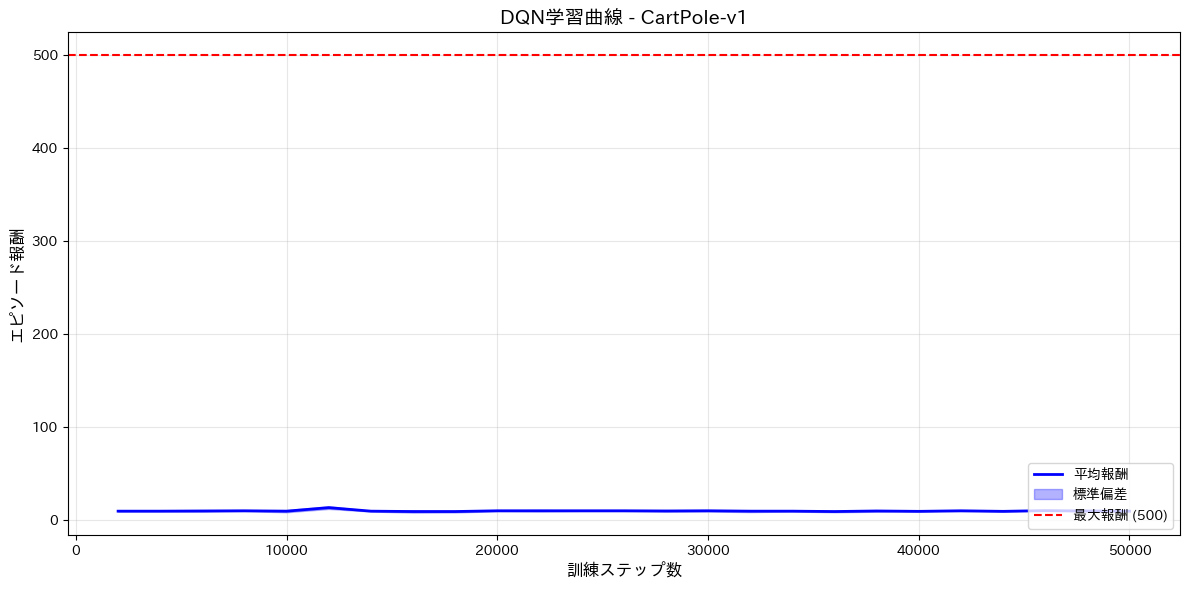


学習の進捗:
  初期パフォーマンス: 9.20
  最終パフォーマンス: 9.20
  改善率: 0.0%


In [6]:
# 学習曲線のプロット
plt.figure(figsize=(12, 6))

# 平均報酬と標準偏差
timesteps = np.array(callback.timesteps)
mean_rewards = np.array(callback.mean_rewards)
std_rewards = np.array(callback.std_rewards)

plt.plot(timesteps, mean_rewards, 'b-', linewidth=2, label='平均報酬')
plt.fill_between(
    timesteps,
    mean_rewards - std_rewards,
    mean_rewards + std_rewards,
    alpha=0.3,
    color='blue',
    label='標準偏差'
)

# 目標ライン（CartPole-v1の最大報酬）
plt.axhline(y=500, color='r', linestyle='--', linewidth=1.5, label='最大報酬 (500)')

# グラフの装飾
plt.xlabel('訓練ステップ数', fontsize=12)
plt.ylabel('エピソード報酬', fontsize=12)
plt.title('DQN学習曲線 - CartPole-v1', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n学習の進捗:")
print(f"  初期パフォーマンス: {mean_rewards[0]:.2f}")
print(f"  最終パフォーマンス: {mean_rewards[-1]:.2f}")
print(f"  改善率: {((mean_rewards[-1] - mean_rewards[0]) / mean_rewards[0] * 100):.1f}%")

## 6. 訓練済みエージェントの可視化

訓練済みDQNエージェントの実際の動作を確認します。

In [7]:
def create_animation(model, env, n_steps=500):
    """
    エージェントの動作をアニメーション化
    
    Args:
        model: 訓練済みモデル
        env: Gym環境
        n_steps: 最大ステップ数
    
    Returns:
        animation: matplotlibアニメーション
    """
    frames = []
    obs, info = env.reset()
    done = False
    step = 0
    total_reward = 0
    
    while not done and step < n_steps:
        # フレームを記録
        frame = env.render()
        frames.append(frame)
        
        # 行動を予測
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        total_reward += reward
        step += 1
    
    print(f"エピソード完了: {step}ステップ, 累積報酬: {total_reward:.0f}")
    
    # アニメーション作成
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.axis('off')
    img = ax.imshow(frames[0])
    
    def animate(i):
        img.set_data(frames[i])
        ax.set_title(f'DQNエージェント - ステップ {i+1}/{len(frames)}', fontsize=12)
        return [img]
    
    anim = animation.FuncAnimation(
        fig, animate, frames=len(frames), interval=50, blit=True
    )
    plt.close()
    
    return anim

# アニメーション作成
env = gym.make('CartPole-v1', render_mode='rgb_array')
anim = create_animation(model, env)
env.close()

# アニメーション表示
HTML(anim.to_jshtml())

エピソード完了: 11ステップ, 累積報酬: 11


## 7. DQNの特徴と学習の観察

### DQNの主な特徴

1. **Experience Replay**: 過去の経験をバッファに保存し、ランダムにサンプリングして学習することで、データの相関を減らし、学習を安定化

2. **Target Network**: 別のネットワークで目標値を計算することで、学習の振動を抑制

3. **ε-greedy探索**: 初期は高い探索率で環境を探索し、徐々に最適な行動を選択するように移行

### 学習曲線の観察ポイント

- **初期段階（0-10,000ステップ）**: 探索が多く、パフォーマンスが不安定
- **中期段階（10,000-30,000ステップ）**: 徐々に良い戦略を学習し、報酬が増加
- **後期段階（30,000-50,000ステップ）**: 最適な戦略に収束し、安定した高報酬を達成

### 次のステップ

次のノートブック（02_ppo_basic.ipynb）では、PPOアルゴリズムを使って同じ問題を解き、DQNとの違いを比較します。

## 8. モデルの保存（オプション）

訓練済みモデルを保存して、後で再利用できるようにします。

In [8]:
# モデルの保存
model_path = "../ml/models/dqn_cartpole.zip"
model.save(model_path)
print(f"✅ モデルを保存しました: {model_path}")

# モデルの読み込み例
# loaded_model = DQN.load(model_path)
# print("✅ モデルを読み込みました")

✅ モデルを保存しました: ../ml/models/dqn_cartpole.zip


## まとめ

このノートブックでは、DQNアルゴリズムを使ってCartPole環境でエージェントを訓練しました：

✅ DQNの基本概念（Experience Replay、Target Network、ε-greedy探索）を理解

✅ Stable-Baselines3を使ってDQNエージェントを訓練

✅ 学習曲線を記録し、訓練中のパフォーマンス向上を可視化

✅ 訓練済みエージェントの動作を確認

次のステップでは、PPOアルゴリズムを使って同じ問題を解き、DQNとの違いを比較します。